In [2]:
import sys
sys.path.append("../") # Enables importing from parent directory
import smtplib, ssl
import os
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.image import MIMEImage
from fpl_draft_league import utils
import pandas as pd
import matplotlib.pyplot as plt

## Build the standings chart

In [3]:
standings_df = utils.get_data('standings')
league_entries_df = utils.get_data('league_entries')

standings_df = (pd.merge(standings_df,
                         league_entries_df,
                         left_on='league_entry',
                         right_on='id'
                        )
                .drop(columns=['entry_id', 'id', 'joined_time', 'player_last_name'])
                   .rename(columns={'player_first_name':'team'}))

standings_df

,last_rank,league_entry,matches_drawn,matches_lost,matches_played,matches_won,points_against,points_for,rank,rank_sort,total,entry_name,team,short_name,waiver_pick
0,1,199619,0,7,38,18,873,1113,1,1,54,Cocu-doodle-doo,Dave,DH,10
1,2,361492,0,9,38,16,926,941,2,2,48,Auto Pick FC,ben,bs,9
2,3,174967,2,10,38,13,937,1028,3,3,41,Mein Bergkampf,Liam,LG,8
3,4,405873,0,12,38,13,1001,1100,4,4,39,Beared Goat,Cory,CC,7
4,5,174291,0,12,38,13,973,1014,5,5,39,Liquid Football,James,JF,6
5,6,177091,0,12,38,13,970,943,6,6,39,15 for 1,Thomas,TG,5
6,8,144429,1,13,38,11,918,879,7,7,34,HanksYouAndGoodnight,Benji,BH,4
7,7,174248,0,14,38,11,993,949,8,8,33,Wado Wanderers,John,JW,3
8,10,173794,0,17,38,8,1042,777,9,9,24,RP’s Perks,Rebecca,RP,2
9,9,197646,1,17,38,7,901,790,10,10,22,The Boyz,Huw,HL,1


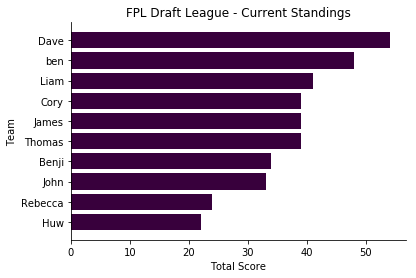

In [4]:
plt.figure()
plt.barh(range(10),
         standings_df['total'],
         tick_label=standings_df['team'],
         color='#38003c')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('FPL Draft League - Current Standings')
ax.set_xlabel('Total Score')
ax.set_ylabel('Team')
ax.invert_yaxis()

## Build the top 10 player scores

Pull the latest gameweek data for all football player

In [5]:
df = utils.get_team_players_gw_data()
df = df[df['event'] == utils.get_num_gameweeks()]

Get the owned players and who the owner is

In [6]:
element_status_df = utils.get_data('element_status')
element_status_df = element_status_df[element_status_df['status'] == 'o']
element_status_df = element_status_df[['element', 'owner']]

le_df = utils.get_data('league_entries')
le_df
le_df = le_df[['player_first_name', 'entry_id']]

owner_df = pd.merge(element_status_df, le_df, how='left', left_on='owner', right_on='entry_id')
owner_df = owner_df.drop(columns=['owner', 'entry_id'])

elements_df = utils.get_data('elements')
elements_df = elements_df[['id', 'web_name']]

po_df = pd.merge(owner_df, elements_df, left_on='element', right_on='id')
po_df = po_df.drop(columns=['id'])
po_df.head(3)

,element,player_first_name,web_name
0,367,Rebecca,Foster
1,169,James,Schmeichel
2,83,Cory,Tarkowski


In [7]:
element_types = utils.get_data

In [8]:
players_df = pd.merge(df,
              po_df,
              how='left',
              left_on='element',
              right_on='element')

players_df = players_df[['web_name', 'player_first_name', 'total_points', 'goals_scored', 'goals_conceded', 'assists', 'bonus']]

players_df.sort_values(by='total_points', ascending=False).head(10)

,web_name,player_first_name,total_points,goals_scored,goals_conceded,assists,bonus
20,Rüdiger,Thomas,16,2,2,0,3
57,Salah,Huw,16,2,0,0,3
34,Mina,Benji,15,2,2,0,3
102,Lloris,John,15,0,0,0,3
60,Henderson,Dave,13,1,0,1,2
54,Firmino,James,11,0,0,3,0
134,Henderson,Rebecca,10,0,0,0,3
133,Mount,Cory,10,0,2,2,2
86,Krul,Thomas,10,0,0,0,2
9,Aké,John,9,1,1,0,1


In [9]:
top10 = players_df.sort_values(by='total_points', ascending=False).head(10)

In [10]:
top10

,web_name,player_first_name,total_points,goals_scored,goals_conceded,assists,bonus
20,Rüdiger,Thomas,16,2,2,0,3
57,Salah,Huw,16,2,0,0,3
34,Mina,Benji,15,2,2,0,3
102,Lloris,John,15,0,0,0,3
60,Henderson,Dave,13,1,0,1,2
54,Firmino,James,11,0,0,3,0
134,Henderson,Rebecca,10,0,0,0,3
133,Mount,Cory,10,0,2,2,2
86,Krul,Thomas,10,0,0,0,2
9,Aké,John,9,1,1,0,1


In [11]:
colour_dict = {
    'Thomas': 
        {
            'color':'#04f5ff',
            'hatch':True
        },
    'Huw':
        {
            'color':'#e90052',
            'hatch':True
        },
    'Benji':
        {
            'color':'#00ff85',
            'hatch':True
        },
    'John':
        {
            'color':'#38003c',
            'hatch':True
        },
    'Dave':
        {
            'color':'#EAFF04',
            'hatch':True
        },
    'James':
        {
            'color':'#04f5ff',
            'hatch':False
        },
    'Rebecca':
        {
            'color':'#e90052',
            'hatch':False
        },
    'Cory':
        {
            'color':'#00ff85',
            'hatch':False
        },
    'Liam':
        {
            'color':'#38003c',
            'hatch':False
        },
    'ben':
        {
            'color':'#EAFF04',
            'hatch':False
        }
}


In [14]:
player_list = list(top10['player_first_name'])

for player in player_list:
    print(colour_dict[player]['color'])

#04f5ff
#e90052
#00ff85
#38003c
#EAFF04
#04f5ff
#e90052
#00ff85
#04f5ff
#38003c


In [186]:
player_list

['Thomas',
 'Huw',
 'Benji',
 'John',
 'Dave',
 'James',
 'Rebecca',
 'Cory',
 'Thomas',
 'John']

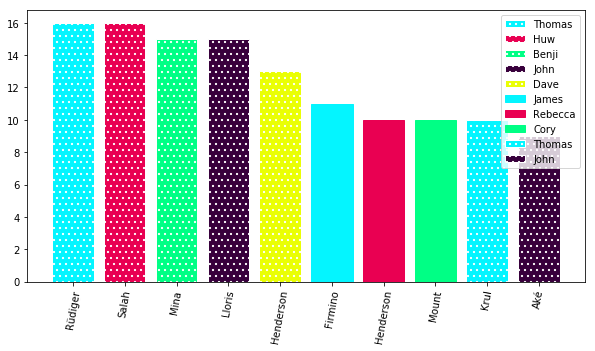

In [20]:
plt.figure(figsize=[10,5])

mybar = plt.bar(range(10),
        top10['total_points'],
        tick_label=top10['web_name']
        )


# for i in range(10):
#     mybar.patches[i].set_hatch('/')


for i, player in zip(range(10), player_list):
    mybar[i].set_color(colour_dict[player]['color'])
    mybar[i].set_label(player)
 

    if colour_dict[player]['hatch'] == True:
        mybar.patches[i].set_hatch('..')
        mybar.patches[i].set_edgecolor('white')
        mybar.patches[i].set_facecolor(colour_dict[player]['color'])

ax = plt.gca()
ax.legend()
# for the legend need to follow this https://stackoverflow.com/questions/23317150/python-matplotlib-legend-shows-first-entry-of-a-list-only
plt.xticks(rotation=80)
plt.show()

In [48]:
port = 465
password = os.environ['MY_PASSWORD']
sender_email = "leejghd@gmail.com"
receiver_email = "lee.gower17@gmail.com"
message = """This is a test python email yippee!"""

message = MIMEMultipart("alternative")
message["Subject"] = "A test email"
message["From"] = sender_email
message["To"] = receiver_email

text = """this is just the plain text version"""

html = html = f"""\
<html>
  <body>
    <p>Hi,<br>
       How are you?<br>
       <a href="http://www.realpython.com">Real Python</a> 
       has many great tutorials.
       <br>
       <img src="cid:image2">
       <br>
       <img src="cid:image1" style="width=50px;height:50px;">
       <br>
    </p>
  </body>
</html>
"""

part2 = MIMEText(html, "html")

message.attach(part2)

with open('../data/test.png', 'rb') as image:
    msgImage = MIMEImage(image.read())
    
with open('../data/test2.png', 'rb') as image:
    msgImage2 = MIMEImage(image.read())

msgImage.add_header('Content-ID', '<image1>')
msgImage2.add_header('Content-ID', '<image2>')
message.attach(msgImage)
message.attach(msgImage2)

# Create a secure SSL context
context = ssl.create_default_context()

with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
    server.login("leejghd@gmail.com", password)
    server.sendmail(sender_email, receiver_email, message.as_string())

In [28]:
os.path.dirname(__file__)

NameError: name '__file__' is not defined